# Querying the GitHub API for repositories and organizations

By Stuart Geiger and Jamie Whitacre, made at a SciPy 2016 sprint. See the rendered, interactive, embedable map [here](http://staeiou.github.io/jupyter-orgs-map.html).

In [1]:
!pip install pygithub
!pip install geopy
!pip install ipywidgets

In [2]:
from github import Github

In [3]:
#this is my private login credentials, stored in ghlogin.py
import ghlogin


In [4]:
g = Github(login_or_token=ghlogin.gh_user, password=ghlogin.gh_passwd)

With this Github object, you can get all kinds of Github objects, which you can then futher explore.

In [5]:
user = g.get_user("staeiou")


In [6]:
print(user.name)
print(user.created_at)
print(user.location)

Stuart Geiger
2013-06-14 00:25:39
Berkeley, CA


In [75]:
repo = g.get_repo("jupyter/notebook")

In [76]:
print(repo.name)
print(repo.description)
print(repo.organization)
print(repo.organization.name)
print(repo.language)


notebook
Jupyter Interactive Notebook
Project Jupyter
JavaScript


There are lots of properties of the various objects (repos, users, organizations), but there are also methods that return lists of objects. You need to iterate through these lists, or access them with indexes. What you usually get from these lists are also objects that have their own properties and methods.

In [87]:
commits = repo.get_commits()
commit = commits[0]
print("Author name: ", commit.author.name)
print("Committer name: ", commit.committer.name)
print("Lines added: ", commit.stats.additions)
print("Lines deleted: ", commit.stats.deletions)
print("Commit message:\n---------\n", commit.commit.message)

Author name:  Matthias Bussonnier
Committer name:  GitHub Web Flow
Lines added:  5
Lines deleted:  0
Commit message:
---------
 Merge pull request #1614 from staeiou/master

Add info on how to launch master branch install


datetime.datetime(2016, 4, 22, 15, 32, 15, 287295)

In [100]:
one_month_ago = datetime.datetime.now() - datetime.timedelta(days=30)
net_lines_added = 0
num_commits = 0

for commit in repo.get_commits(since = one_month_ago):
    net_lines_added += commit.stats.additions
    net_lines_added -= commit.stats.deletions
    num_commits += 1
    
print(net_lines_added, num_commits)

76 29


In [80]:
repo.name
type(last_updated_delta)

datetime.timedelta

In [74]:
issues = repo.get_issues()
for issue in issues:
    last_updated_delta = datetime.datetime.now() - issue.updated_at
    if last_updated_delta > datetime.timedelta(days=365):
        print(issue.title, last_updated_delta.days)
    

Plots from IRkernel not displayed on Github 438
ipythonblocks not rendering on github.com 429
Alphabetical file list honours case of filenames 483
nbviewer doesn't accept branchnames with slashes 519
Build search functionality  505
Running nbviewer within a corporate setting 441
ENH: Add a jquery.tocify outline 505
add Gitlab support 505
widget support 502
Tracking Trending Notebooks 502
nbviewer URLs when transfering Github repos 707
Cell with HTML page renders incorrectly in NBViewer 500
nbviewer : render git repository served by webgit 505
Support gist urls with anchors 699
Github authentication for private repository notebook rendering 488
Convert ipython notebook to pdf and/or print notebook 505
URL blacklist 801
Set max-height: px and overflow:scroll in nbviewer (like it is in a notebook) 439
Feature Request: Add a top or trending notebooks display on the homepage to show most popular notebooks  827
External links in notebook collections go to nbviewer URLs, don't get re-directed

## Organizations

Organizations are objects too, which have similar properties:

In [53]:
org = g.get_organization("jupyter")

In [54]:
print(org.name)
print(org.created_at)
print(org.html_url)

Project Jupyter
2014-04-23 21:36:43
https://github.com/jupyter


The API has a get_public_members() function, but it just shows those who are on the "people" board on the [organization's page](https://github.com/jupyter). You can also see that if someone doesn't have a field set, it returns None. Some people just have usernames set without full names.

In [55]:
for member in org.get_public_members():
    print(member.name, member.url)

Matthias Bussonnier https://api.github.com/users/Carreau
JamieW https://api.github.com/users/JamiesHQ
Corey Stubbs https://api.github.com/users/Lull3rSkat3r
Sylvain Corlay https://api.github.com/users/SylvainCorlay
Afshin Darian https://api.github.com/users/afshin
Steven Silvester https://api.github.com/users/blink1073
Safia Abdalla https://api.github.com/users/captainsafia
Dave Willmer https://api.github.com/users/dwillmer
Fernando Perez https://api.github.com/users/fperez
Paul Ivanov https://api.github.com/users/ivanov
None https://api.github.com/users/jakirkham
Jason Grout https://api.github.com/users/jasongrout
Jonathan Frederic https://api.github.com/users/jdfreder
Jessica B. Hamrick https://api.github.com/users/jhamrick
Min RK https://api.github.com/users/minrk
Peter Parente https://api.github.com/users/parente
Mike https://api.github.com/users/poplav
Kyle Kelley https://api.github.com/users/rgbkrk
Sumit Sahrawat https://api.github.com/users/sumitsahrawat
Thomas Kluyver https://a

We can go through all the repositories in the organization with the get_repos() function. It returns a list of repository objects, which have their own properties and methods.

In [104]:
repo.name

'nbviewer'

In [103]:
for contributor in repo.get_contributors():
    print(contributor.name,contributor.contributions)

Min RK 330
Matthias Bussonnier 231
Kyle Kelley 206
Nicholas Bollweg 142
Brian E. Granger 18
Matt Terry 11


KeyboardInterrupt: 

## Rate limiting

Now that we have made a few requests, we can see what our rate limit is. If you are logged in, you get 5,000 requests per hour. If you are not, you only get 60 per hour. You can use methods in the GitHub object to see your limit, usage, and reset time. We have used less than 50 of our 5,000 requests with these calls.

In [15]:
g.rate_limiting

(4969, 5000)

In [16]:
reset_time = g.rate_limiting_resettime
reset_time

1468970425

This value is in seconds since the UTC epoch (Jan 1st, 1970), so we have to convert it. Here is a quick function that takes a GitHub object, queries the API to find our next reset time, and converts it to minutes.

In [50]:
import datetime
def minutes_to_reset(github):
    reset_time = github.rate_limiting_resettime
    timedelta_to_reset = datetime.datetime.fromtimestamp(reset_time) - datetime.datetime.now()
    return timedelta_to_reset.seconds / 60
    

In [51]:
minutes_to_reset(g)

76.06666666666666

## Getting location data for an organization's contributors
### Mapping and geolocation

Before we get into how to query GitHub, we know we will have to get location coordinates for each contributor, and then plot it on a map. So we are going to do that first.

For geolocation, we are using geopy's geolocator object, which is based on Open Street Map's Nominatim API. Nominatim takes in any arbitrary location data and then returns a location object, which includes the best latitude and longitude coordinates it can find. 

This does mean that we will have more error than if we did this manually, and there might be vastly different levels of accuracy. For example, if someone just has "UK" as their location, it will show up in the geographic center of the UK, which is somewhere on the edge of the Lake District. "USA" resolves to somewhere in Kansas. However, you can get very specific location data if you put in more detail.

In [19]:
from geopy.geocoders import Nominatim

geolocator = Nominatim()
uk_loc = geolocator.geocode("UK")
print(uk_loc.longitude,uk_loc.latitude)

us_loc = geolocator.geocode("USA")
print(us_loc.longitude,us_loc.latitude)

bids_loc = geolocator.geocode("Doe Library, Berkeley CA, 94720 USA")
print(bids_loc.longitude,bids_loc.latitude)

-3.2765752 54.7023545
-100.4458824 39.7837304
-122.259492086406 37.87219435


We can plot points on a map using ipyleaflets and ipywidgets. We first set up a map object, which is created with various parameters. Then we create Marker objects, which are then appended to the map. We then display the map inline in this notebook.

In [20]:
import ipywidgets

from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

center = [30.0, 5.0]
zoom = 2
m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom, layout=ipywidgets.Layout(height="600px"))

uk_mark = Marker(location=[uk_loc.latitude,uk_loc.longitude])
uk_mark.visible
m += uk_mark

us_mark = Marker(location=[us_loc.latitude,us_loc.longitude])
us_mark.visible
m += us_mark

bids_mark = Marker(location=[bids_loc.latitude,bids_loc.longitude])
bids_mark.visible
m += bids_mark

### Querying GitHub for location data

For our mapping script, we want to get profiles for everyone who has made a commit to any of the repositories in the Jupyter organization, find their location (if any), then add it to a list. The API has a get_contributors function for repo objects, which returns a list of contributors ordered by number of commits, but not one that works across all repos in an org. So we have to iterate through all the repos in the org, and run the get_contributors method for We also want to make sure we don't add any duplicates to our list to over-represent any areas, so we keep track of people in a dictionary.

I've written a few functions to make it easy to retreive and map an organization's contributors.

In [43]:
def get_org_contributor_locations(github, org_name):
    """
    For a GitHub organization, get location for contributors to any repo in the org.
    
    Returns a dictionary of {username URLS : geopy Locations}, then a dictionary of various metadata.
    
    """
    
    # Set up empty dictionaries and metadata variables
    contributor_locs = {}
    locations = []
    none_count = 0
    error_count = 0
    user_loc_count = 0
    duplicate_count = 0
    geolocator = Nominatim()

    
    # For each repo in the organization
    for repo in github.get_organization(org_name).get_repos():
        #print(repo.name)
        
        # For each contributor in the repo        
        for contributor in repo.get_contributors():
            print('.', end="")
            # If the contributor_locs dictionary doesn't have an entry for this user
            if contributor_locs.get(contributor.url) is None:
                
                # Try-Except block to handle API errors
                try:
                    # If the contributor has no location in profile
                    if(contributor.location is None):
                        #print("No Location")
                        none_count += 1
                    else:
                        # Get coordinates for location string from Nominatim API
                        location=geolocator.geocode(contributor.location)

                        #print(contributor.location, " | ", location)
                        
                        # Add a new entry to the dictionary. Value is user's URL, key is geocoded location object
                        contributor_locs[contributor.url] = location
                        user_loc_count += 1
                except Exception:
                    print('!', end="")
                    error_count += 1
            else:
                duplicate_count += 1
                
    return contributor_locs,{'no_loc_count':none_count, 'user_loc_count':user_loc_count, 
                             'duplicate_count':duplicate_count, 'error_count':error_count}


With this, we can easily query an organization. The U.D. Digital Service (org name: usds) is a small org that works well for testing. It takes about a second per contributor to get this data, so we want to test on small orgs.

In [42]:
usds_locs, usds_metadata = get_org_contributor_locations(g,'usds')

...............................

In [44]:
usds_metadata

{'duplicate_count': 1,
 'error_count': 0,
 'no_loc_count': 8,
 'user_loc_count': 22}

We are going to explore this dataset, but not plot names or usernames. I'm a bit hesitant to publish location data with unique identifiers, even if people put that information in their profiles. 

In [45]:
usds_locs_nousernames = []
for contributor, location in usds_locs.items():
    usds_locs_nousernames.append(location)
usds_locs_nousernames

[Location(Portland, Multnomah County, Oregon, United States of America, (45.5202471, -122.6741948, 0.0)),
 Location(東京都, 日本, (34.2255804, 139.294774527387, 0.0)),
 Location(D,C, Buccaneer Ridge Drive, Johnson City, Washington County, Tennessee, 37614, United States of America, (36.29885175, -82.3591932141095, 0.0)),
 Location(Washington, District of Columbia, United States of America, (38.8949549, -77.0366455, 0.0)),
 Location(Oakland, Alameda County, California, United States of America, (37.8044557, -122.2713562, 0.0)),
 Location(Washington, District of Columbia, United States of America, (38.8949549, -77.0366455, 0.0)),
 Location(Dayton, Montgomery County, Ohio, United States of America, (39.7589478, -84.1916068, 0.0)),
 Location(Washington, District of Columbia, United States of America, (38.8949549, -77.0366455, 0.0)),
 Location(SF, California, United States of America, (37.7792808, -122.4192362, 0.0)),
 Location(Milwaukee, Milwaukee County, Wisconsin, United States of America, (4

Now we can map this data using another function I have written.

In [46]:
def map_location_dict(map_obj,org_location_dict):
    """
    Maps the locations in a dictionary of {ids : geoPy Locations}. 
    
    Must be passed a map object, then the dictionary. Returns the map object.
    
    """
    for username, location in org_location_dict.items():
        if(location is not None):
            mark = Marker(location=[location.latitude,location.longitude])
            mark.visible
            map_obj += mark
            

    return map_obj

In [48]:
center = [30.0,5.0]
zoom = 2
usds_map = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom, layout=ipywidgets.Layout(height="600px"))

usds_map = map_location_dict(usds_map, usds_locs)

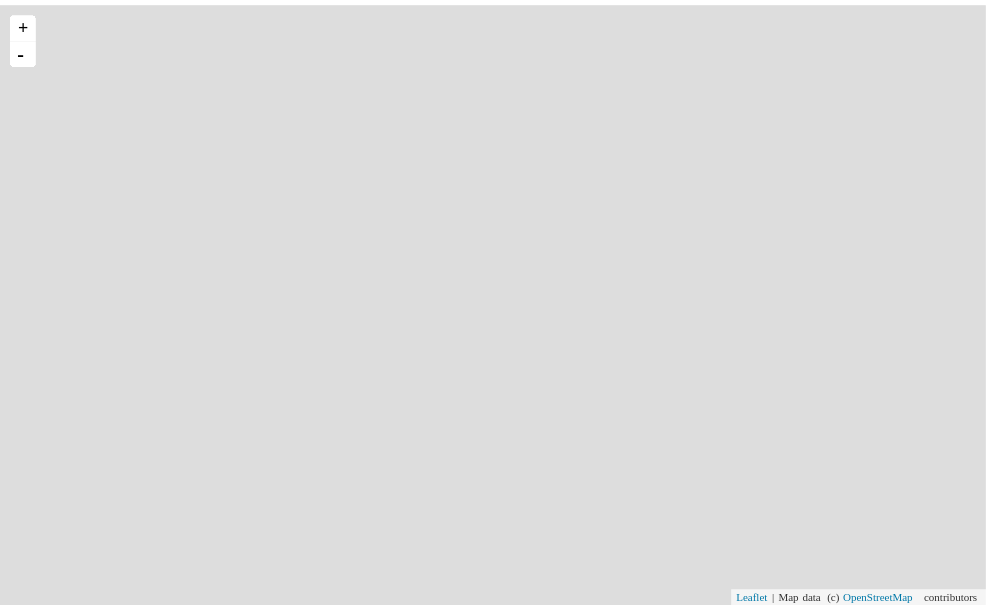

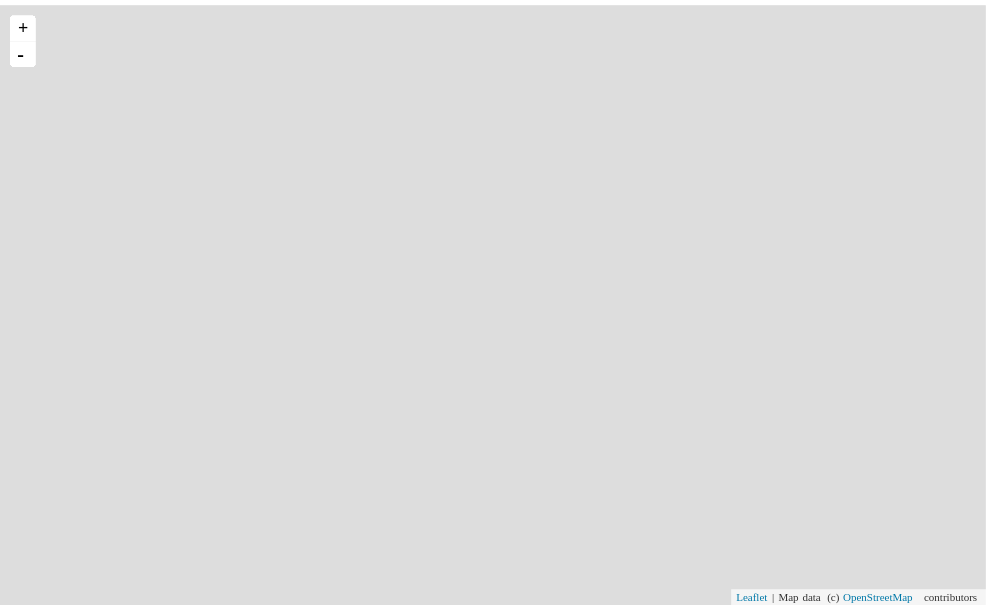

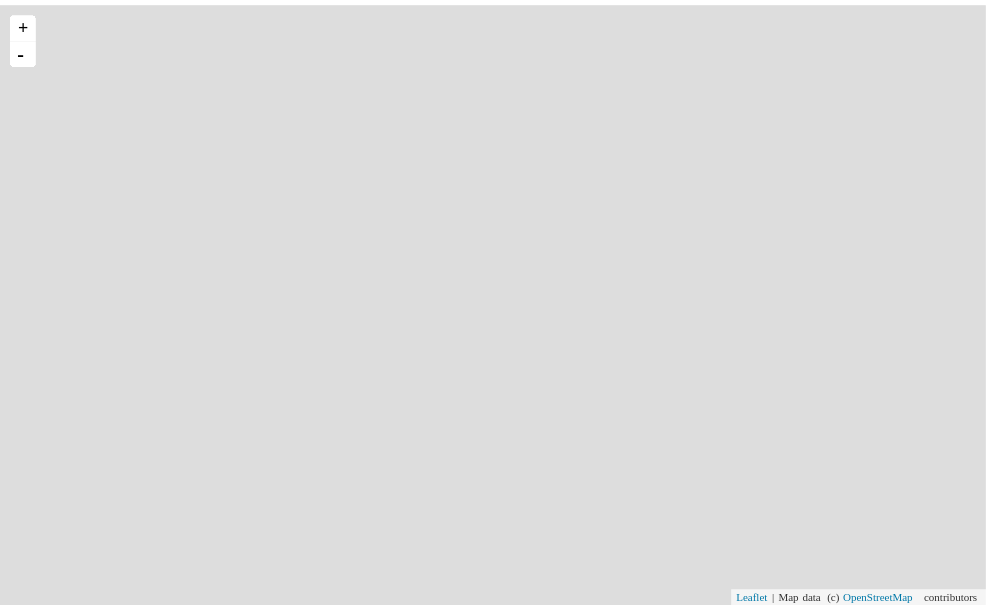

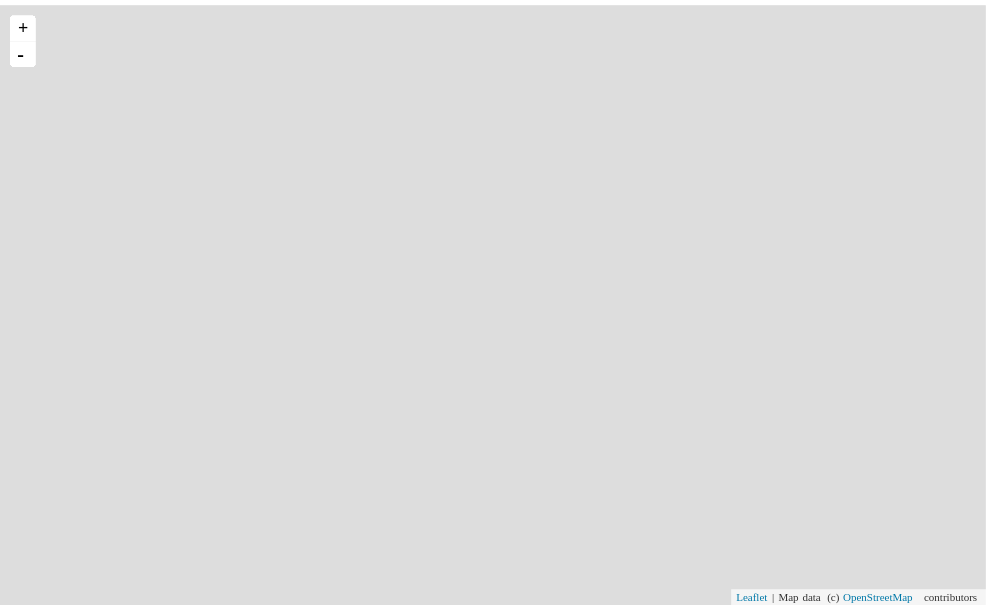

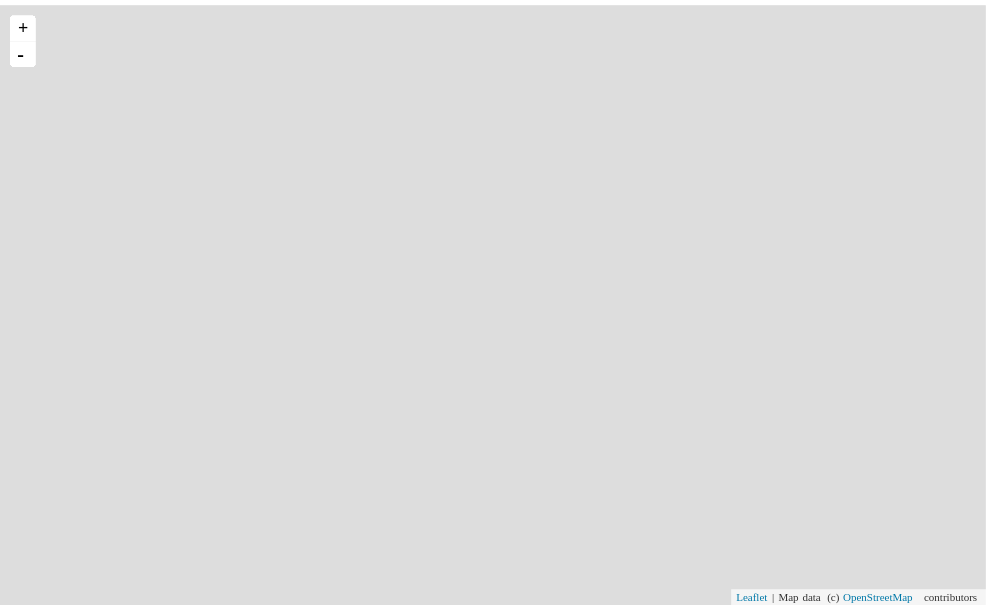

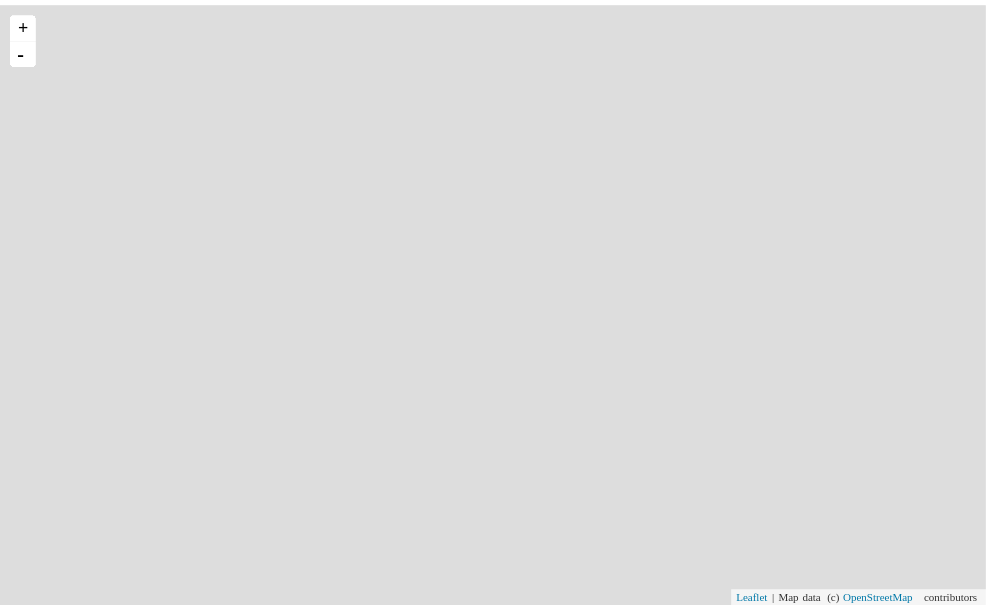

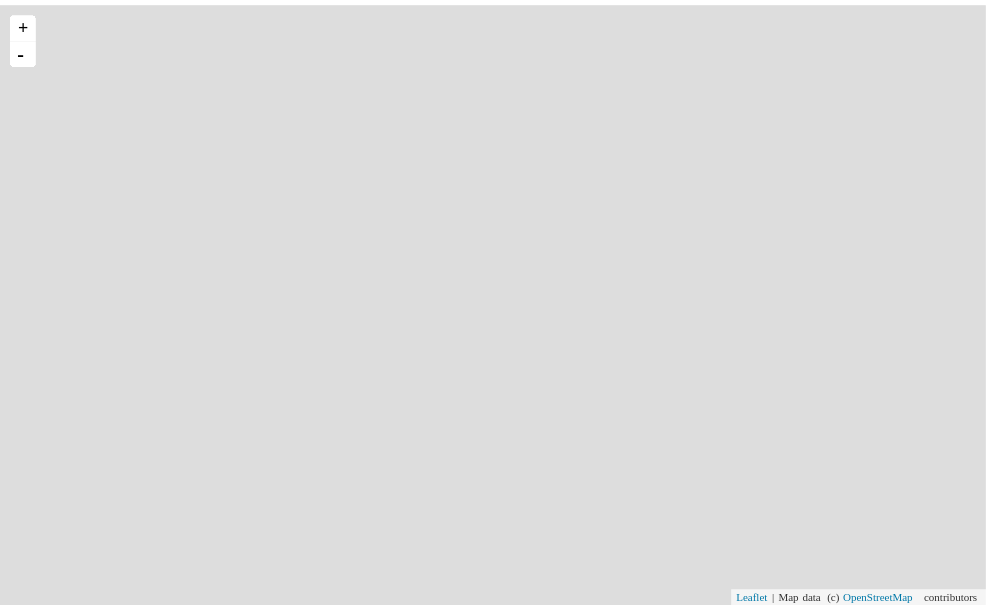

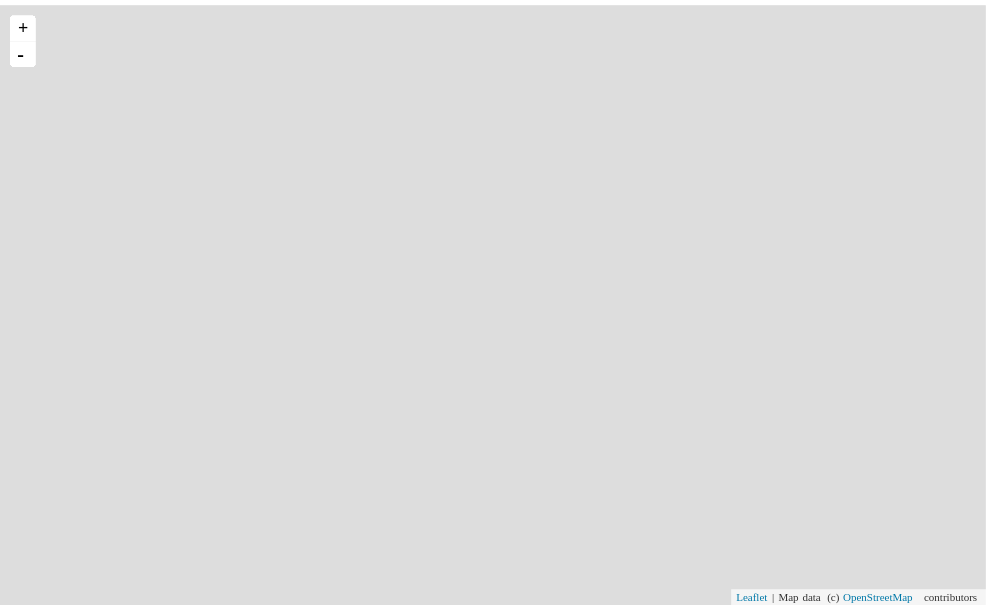

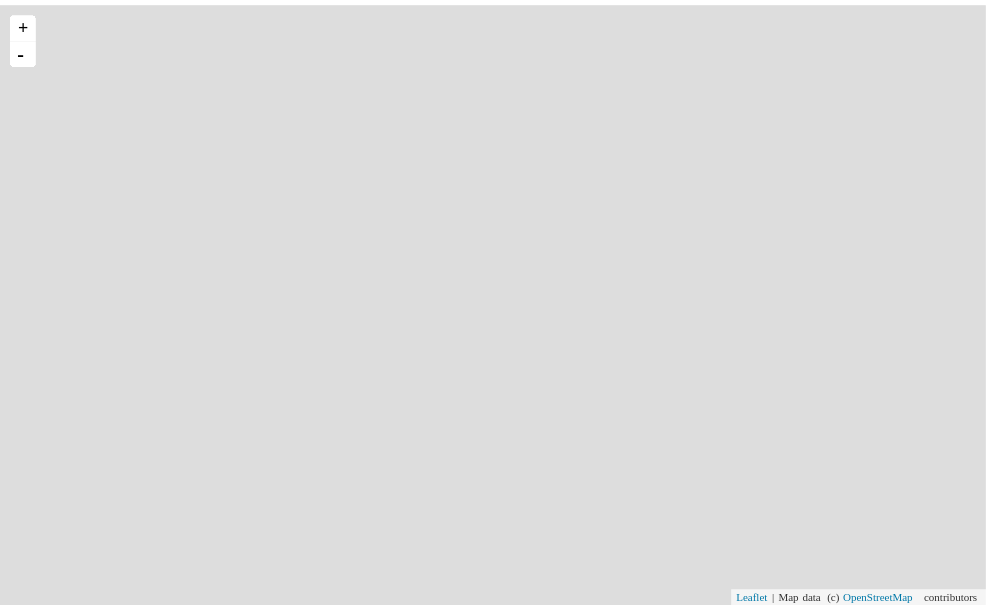

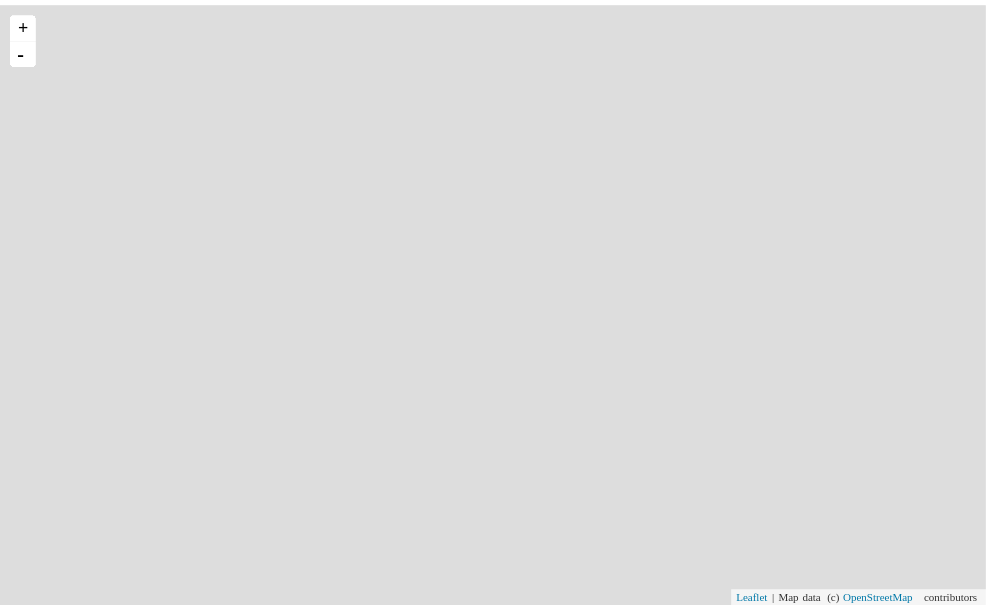

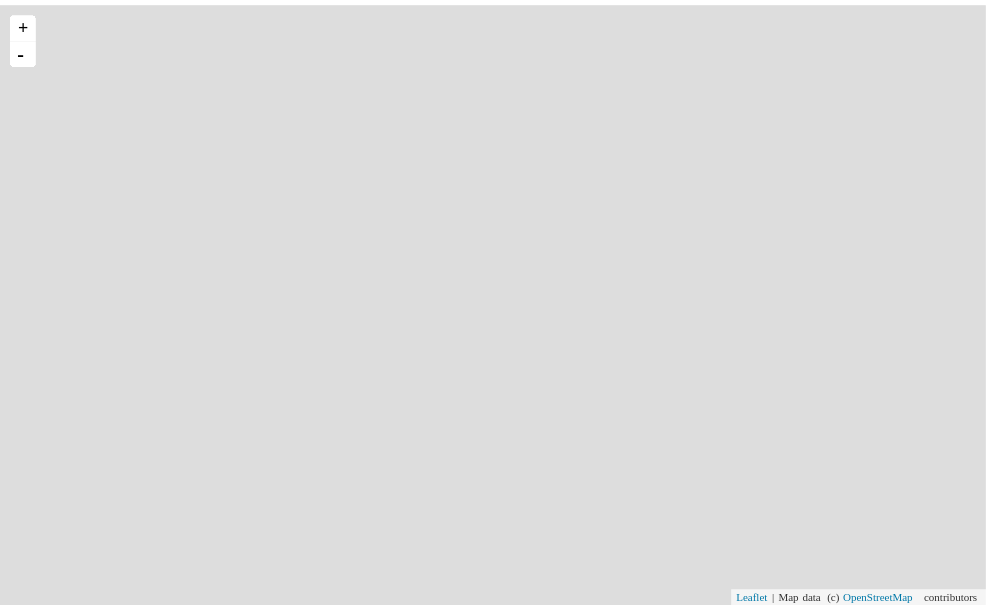

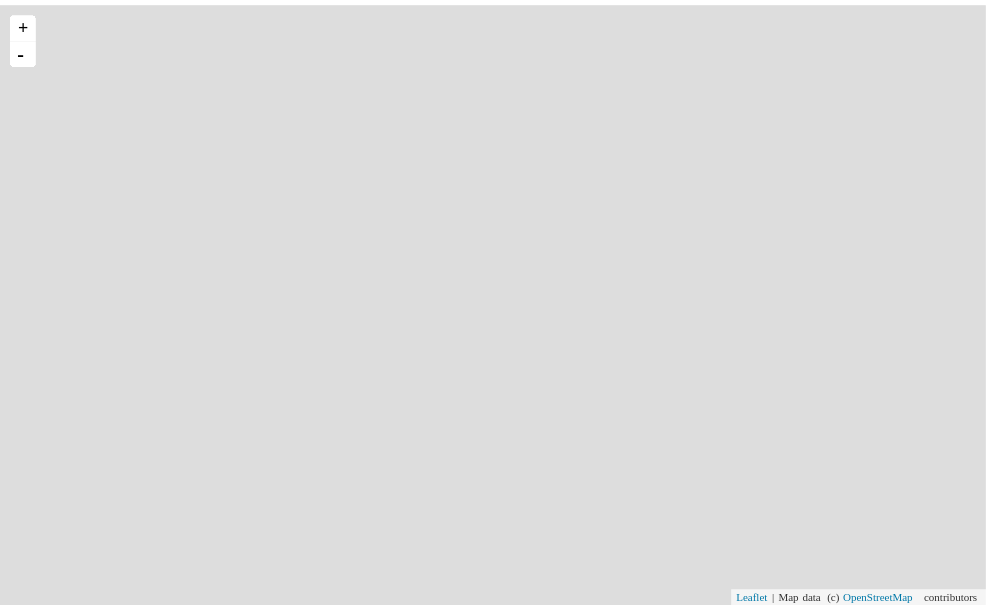

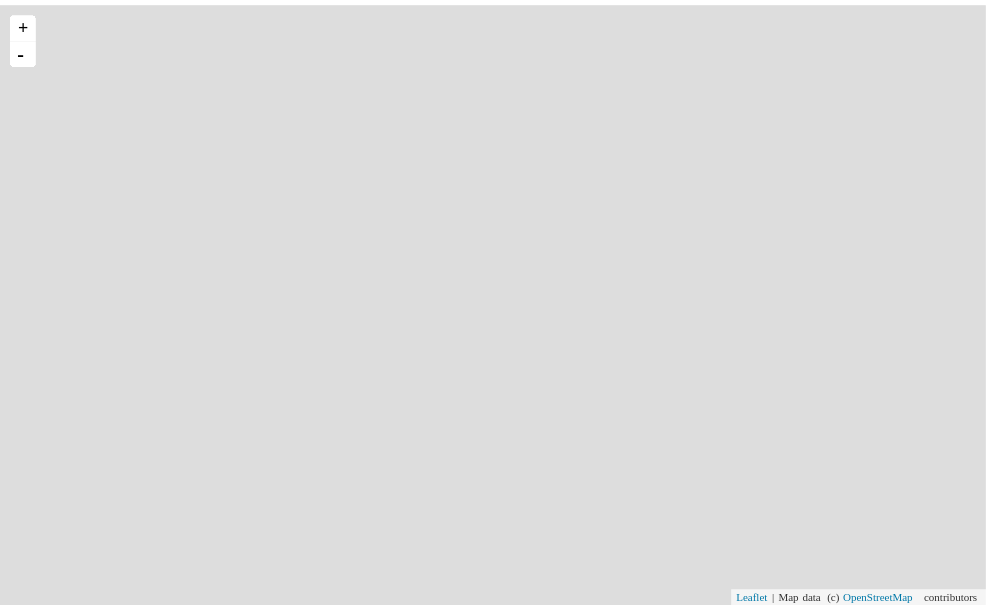

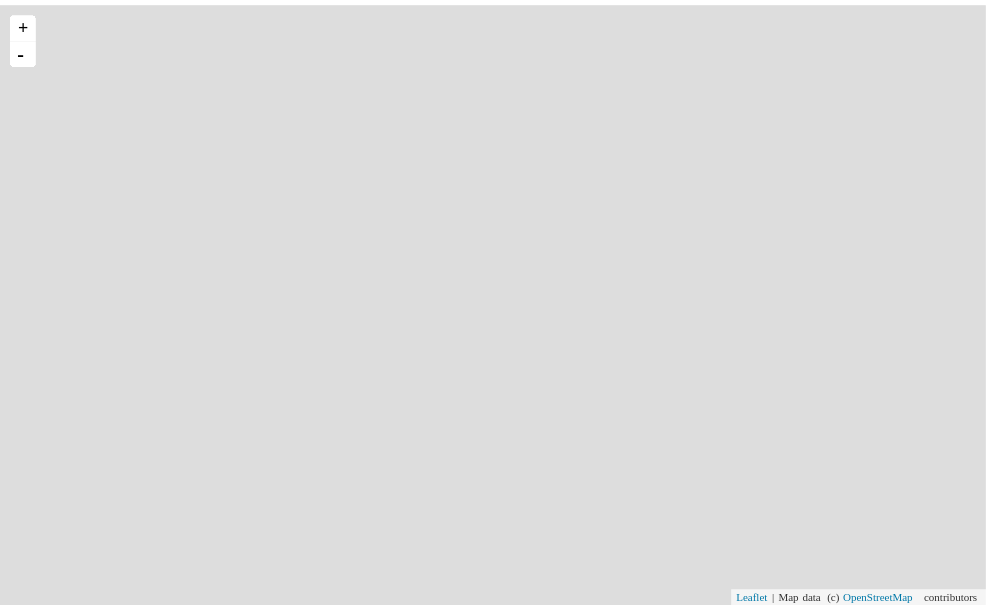

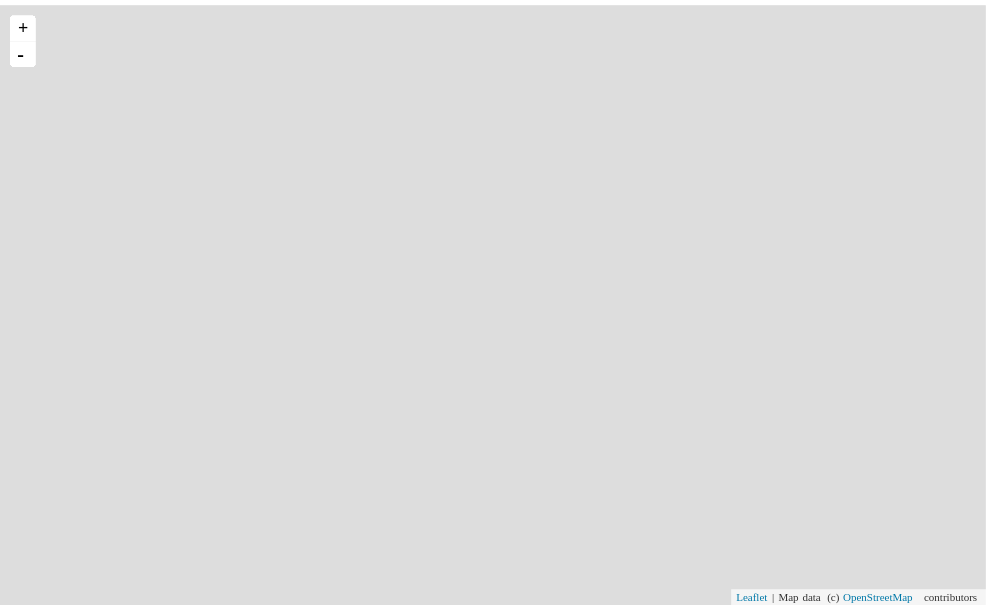

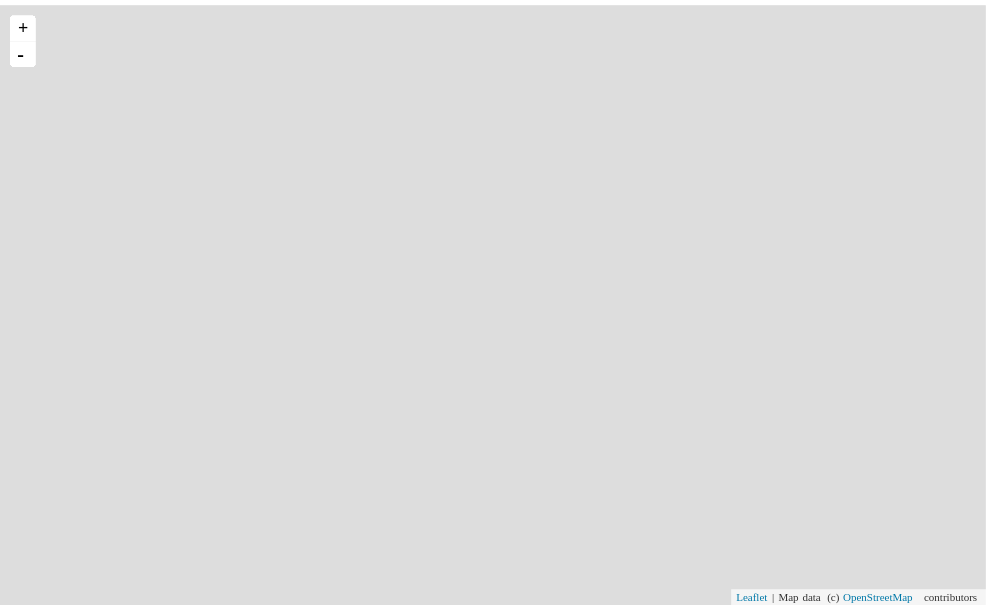

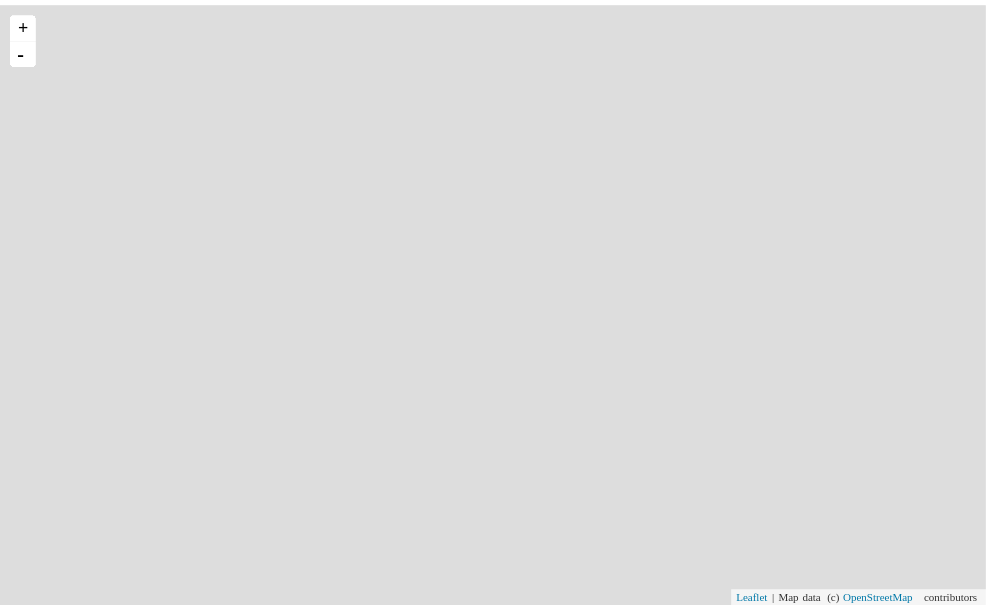

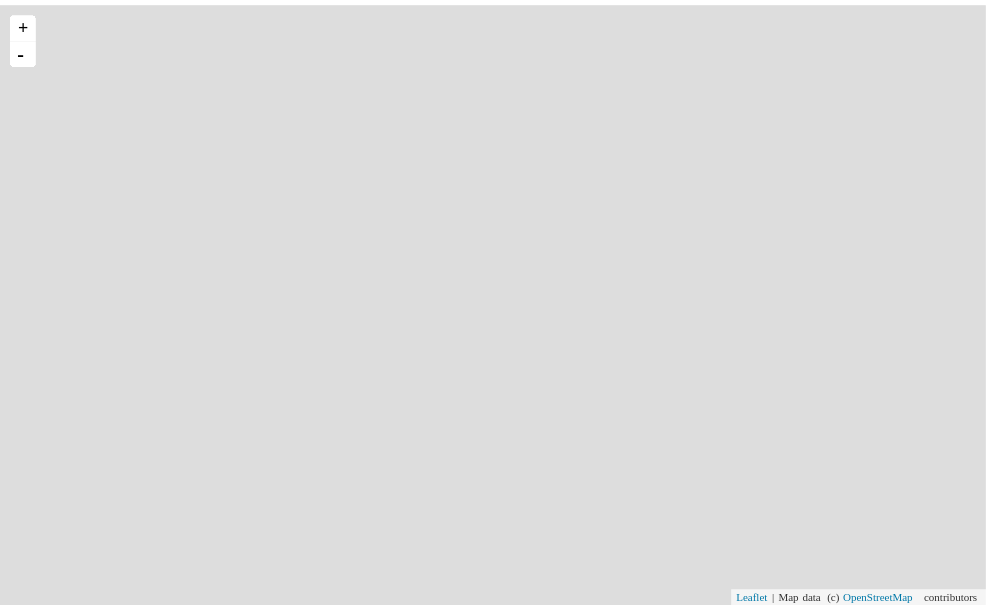

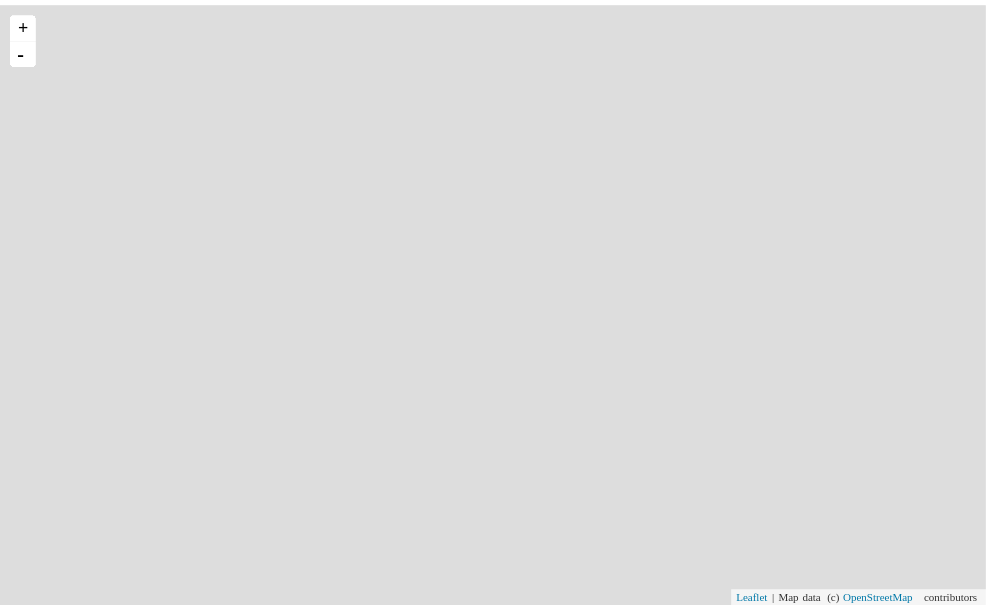

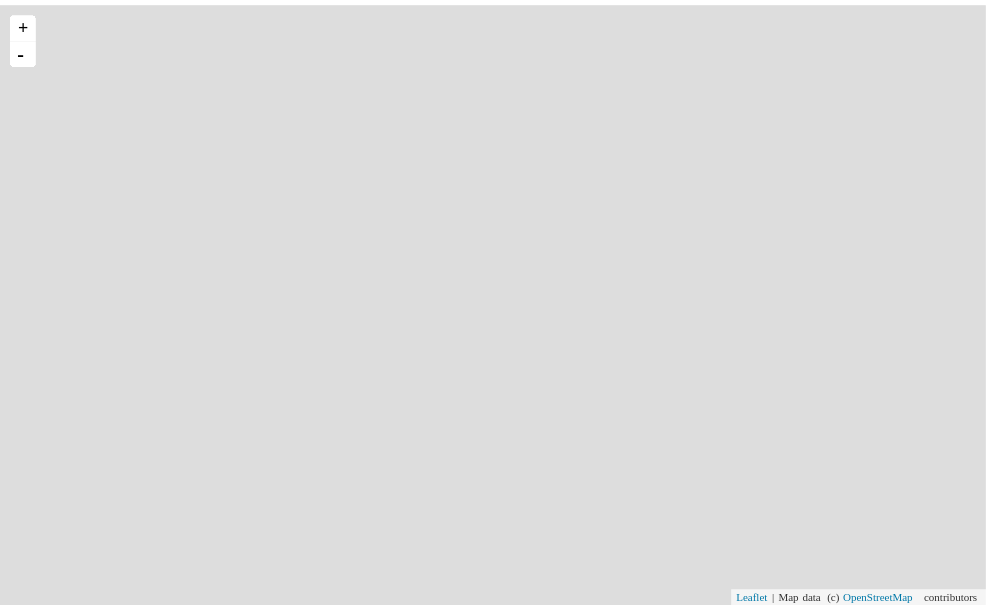

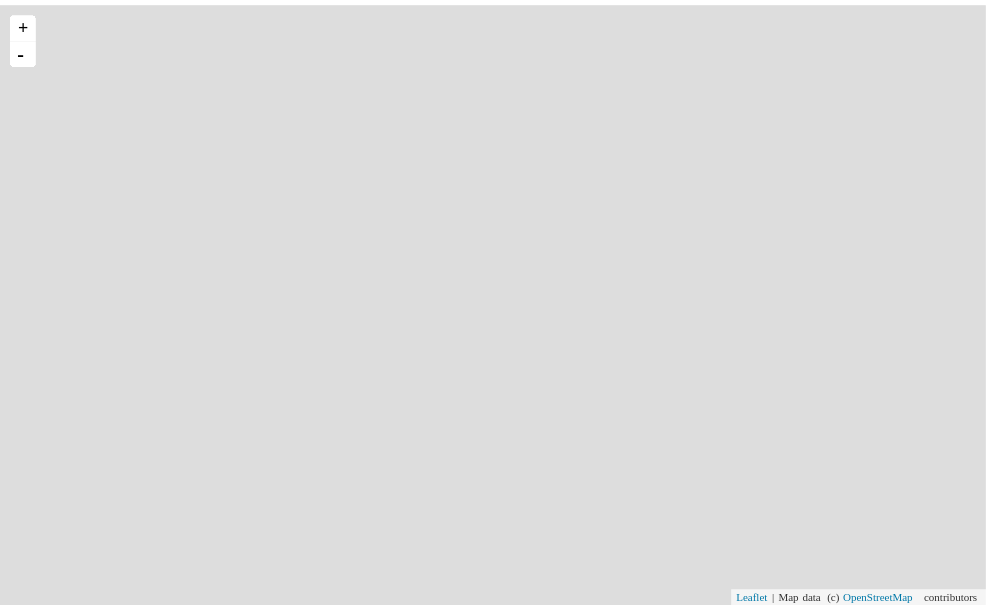

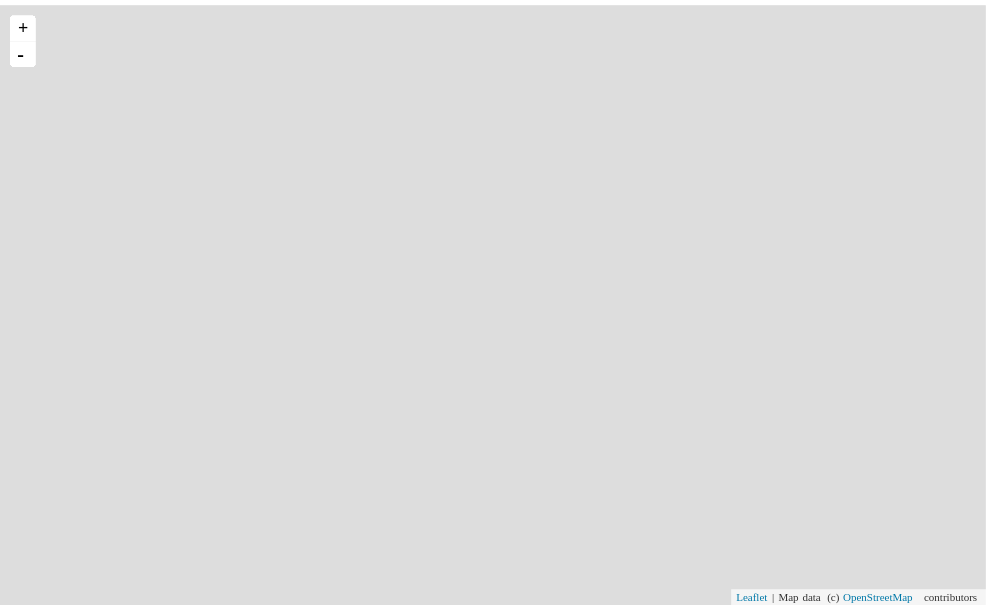

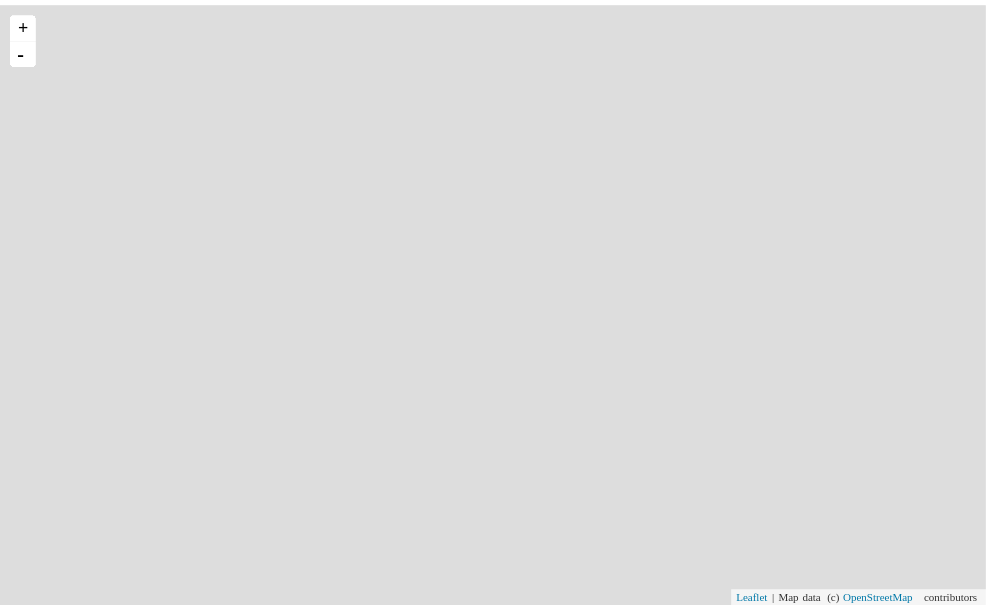

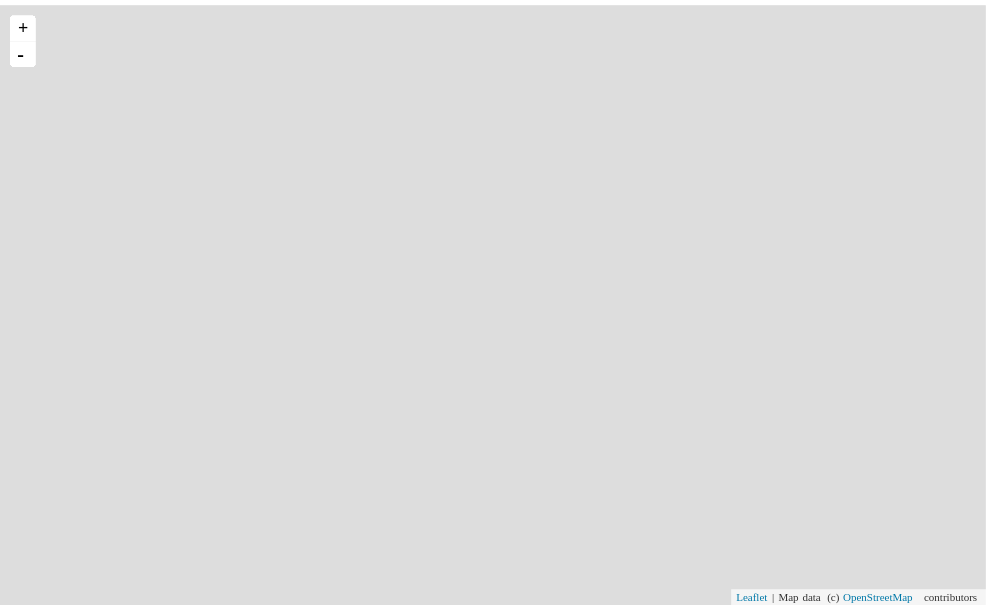

In [49]:
usds_map

## Mapping multiple organizations
Sometimes you have multiple organizations within a group of interest. Because these are functions, they can be combined with some loops.

In [38]:
jupyter_orgs = ['jupyter', 'ipython', 'jupyter-attic','jupyterhub']


In [29]:
orgs_location_dict = {}
orgs_metadata_dict = {}
for org in jupyter_orgs:
    # For a status update, print when we get to a new org in the list
    print(org)
    orgs_location_dict[org], orgs_metadata_dict[org] = get_org_contributor_locations(g,org)

jupyter
ipython
jupyter-attic
jupyterhub


In [105]:
orgs_metadata_dict

{'ipython': {'duplicate_count': 185,
  'error_count': 1,
  'no_loc_count': 307,
  'user_loc_count': 314},
 'jupyter': {'duplicate_count': 322,
  'error_count': 0,
  'no_loc_count': 273,
  'user_loc_count': 322},
 'jupyter-attic': {'duplicate_count': 33,
  'error_count': 0,
  'no_loc_count': 39,
  'user_loc_count': 29},
 'jupyterhub': {'duplicate_count': 35,
  'error_count': 0,
  'no_loc_count': 27,
  'user_loc_count': 46}}

### Plotting the map

In [31]:
center = [30, 5]
zoom = 2
jupyter_orgs_maps = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom, 
                        layout=ipywidgets.Layout(height="600px"))

for org_name,org_location_dict in orgs_location_dict.items():
    jupyter_orgs_maps += map_location_dict(jupyter_orgs_maps,org_location_dict)

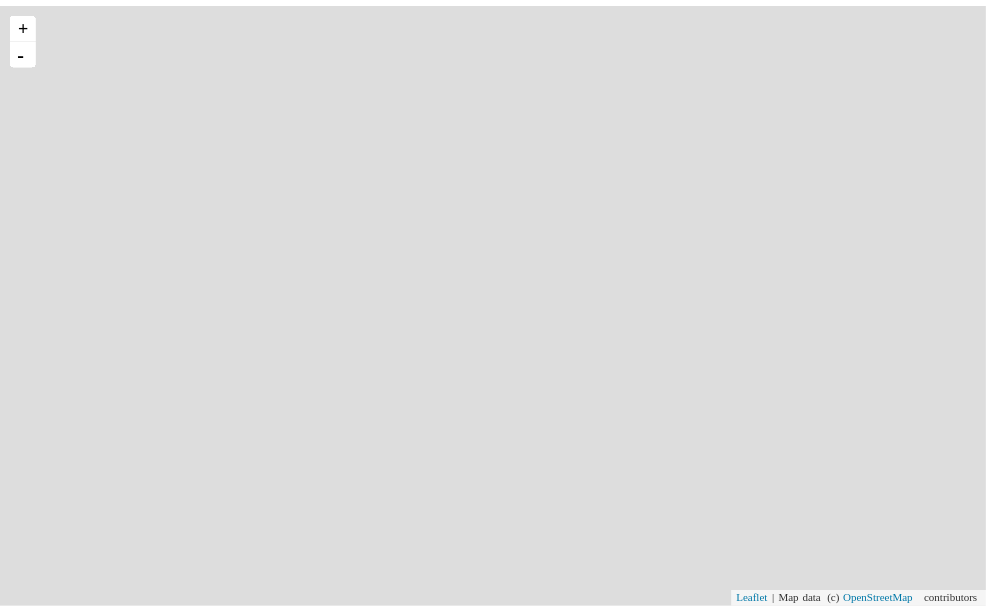

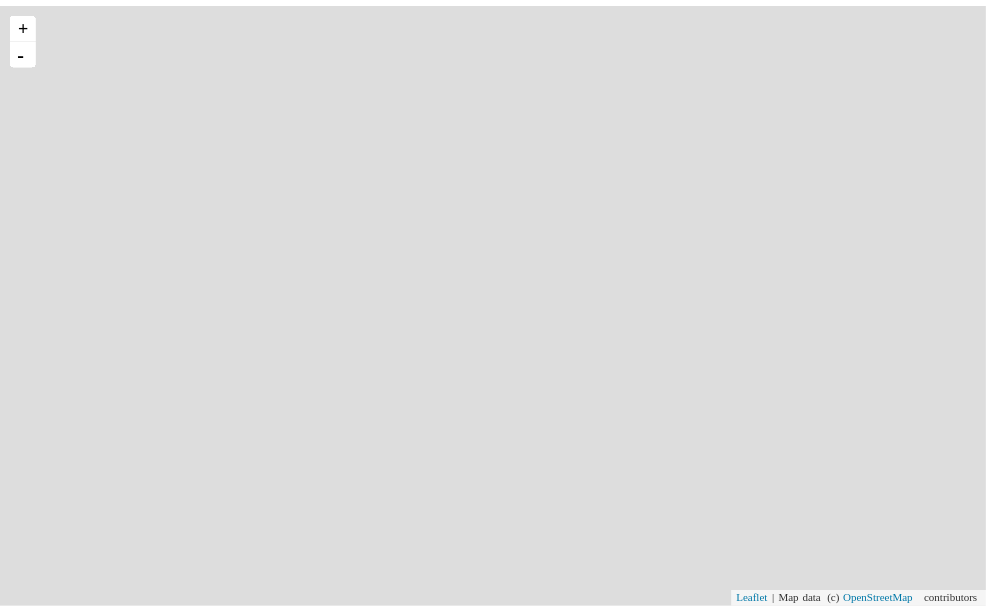

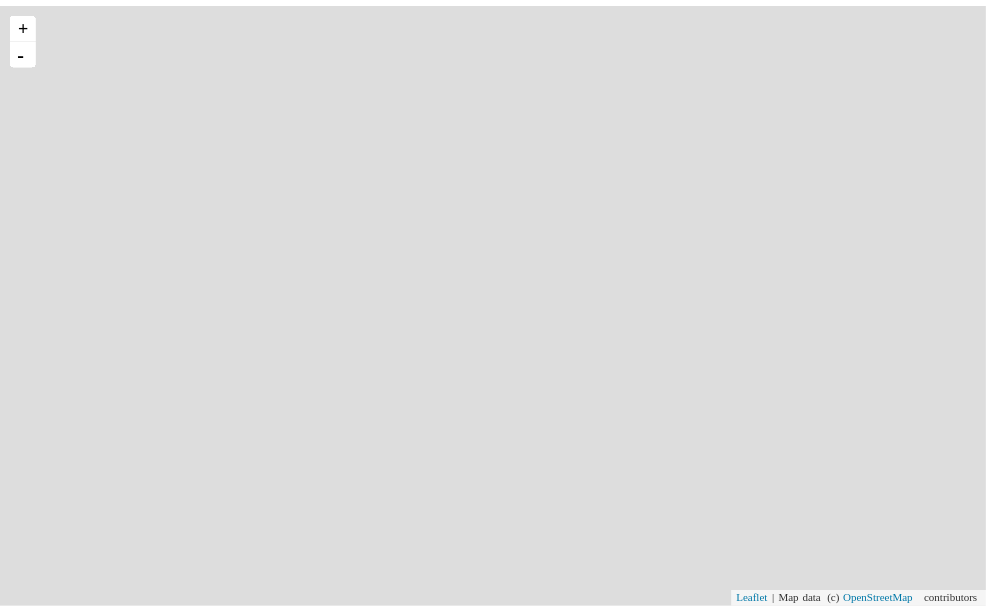

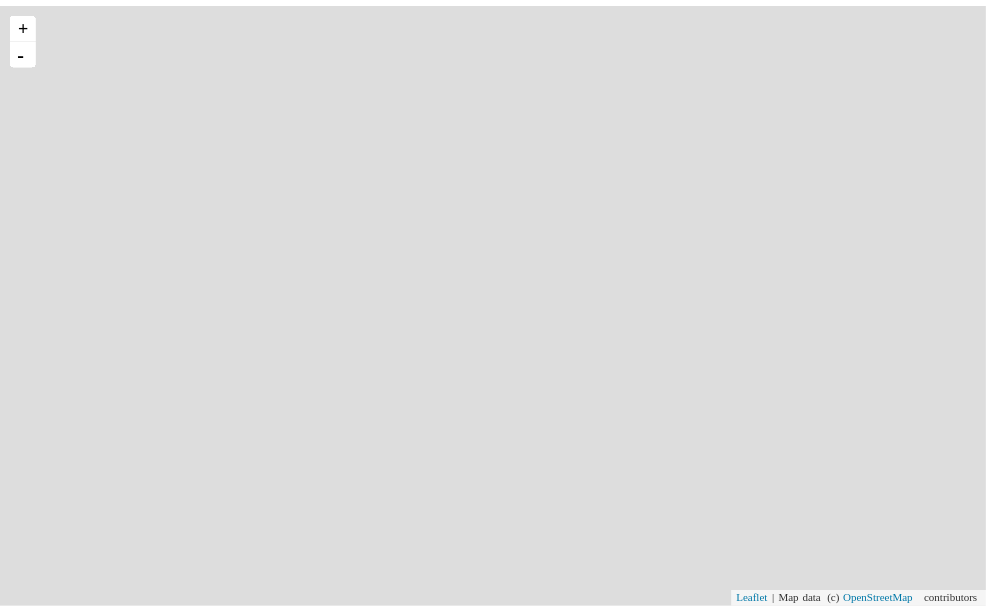

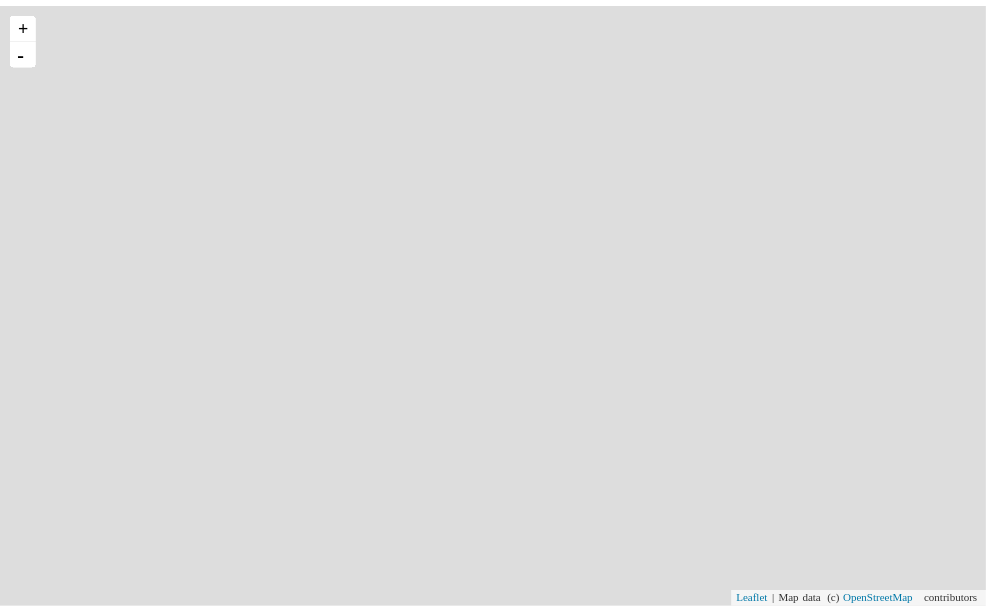

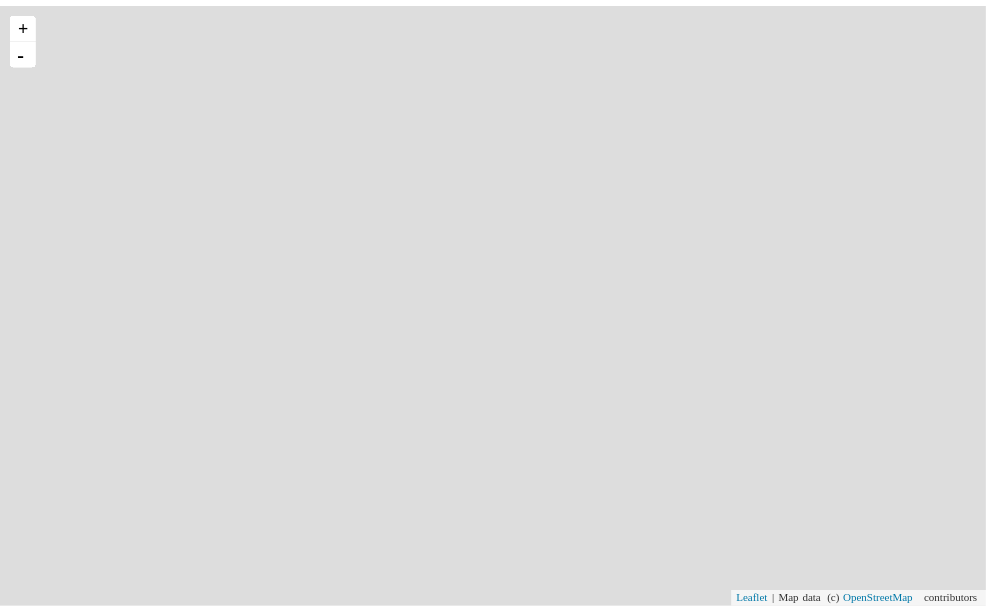

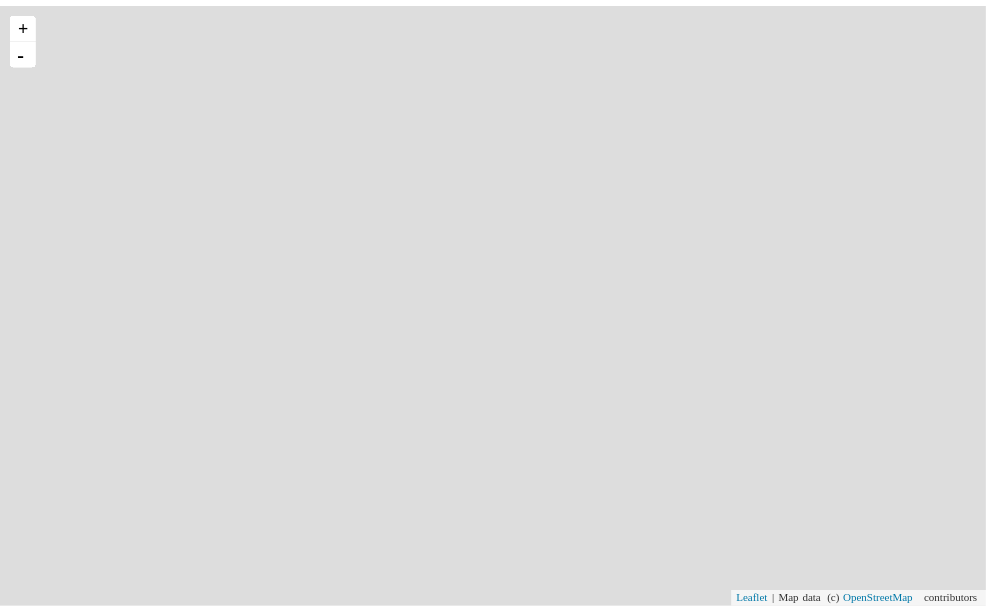

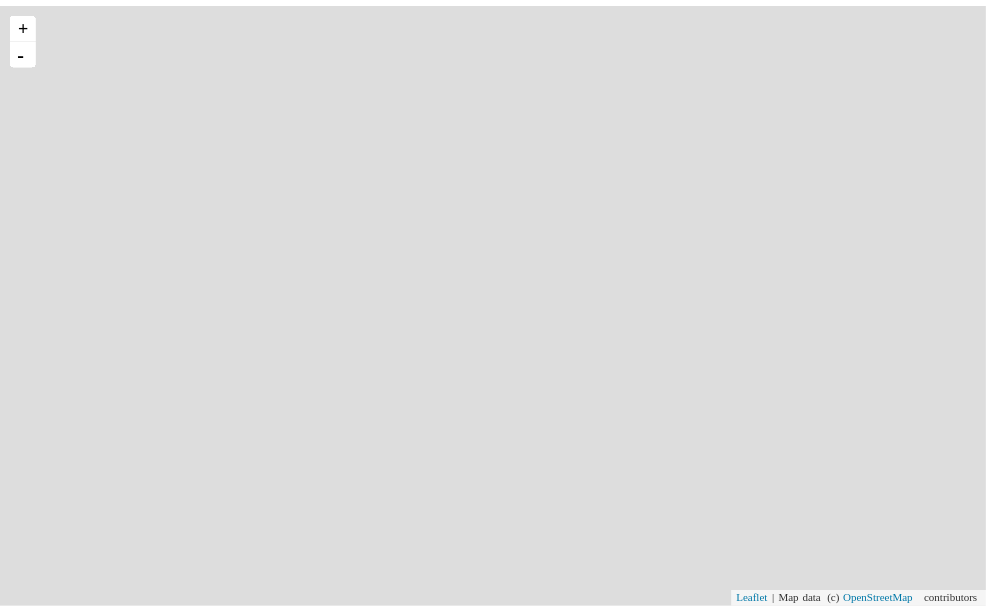

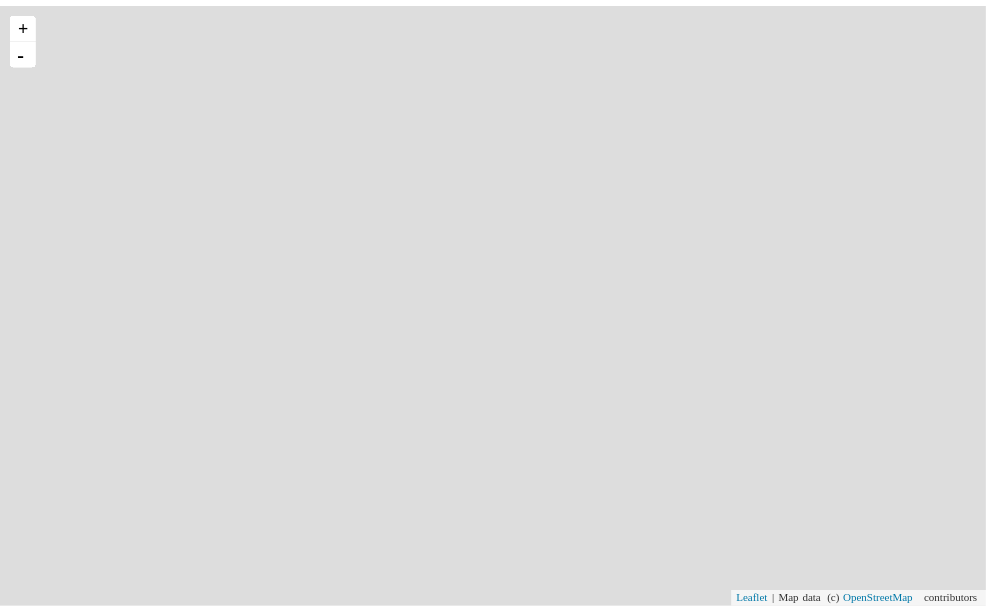

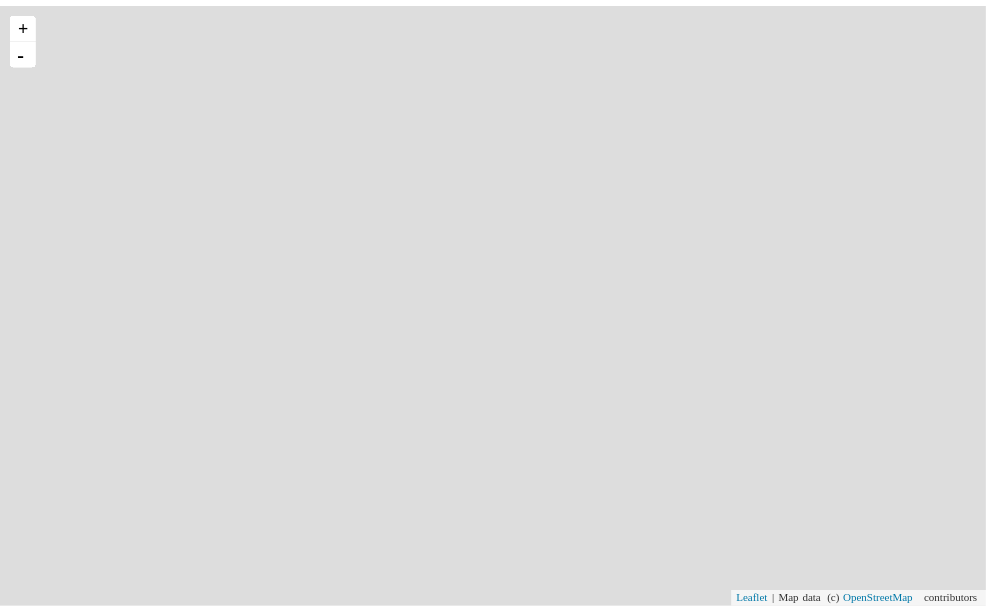

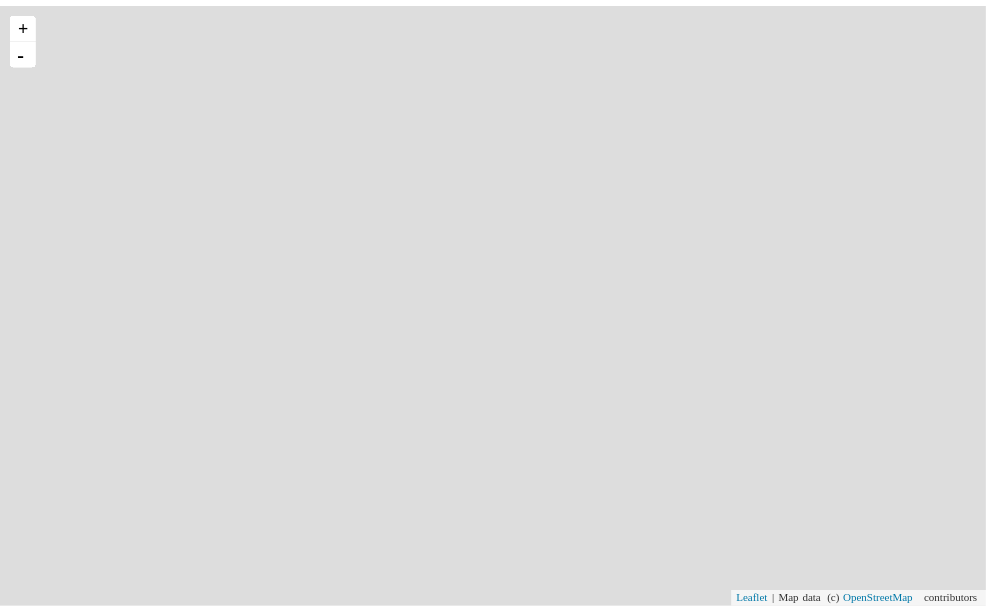

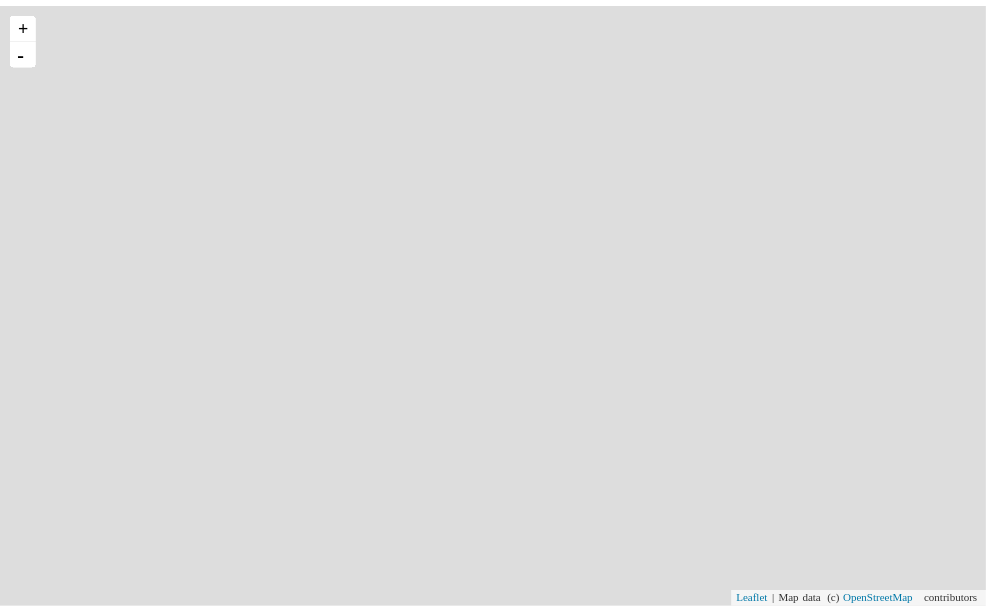

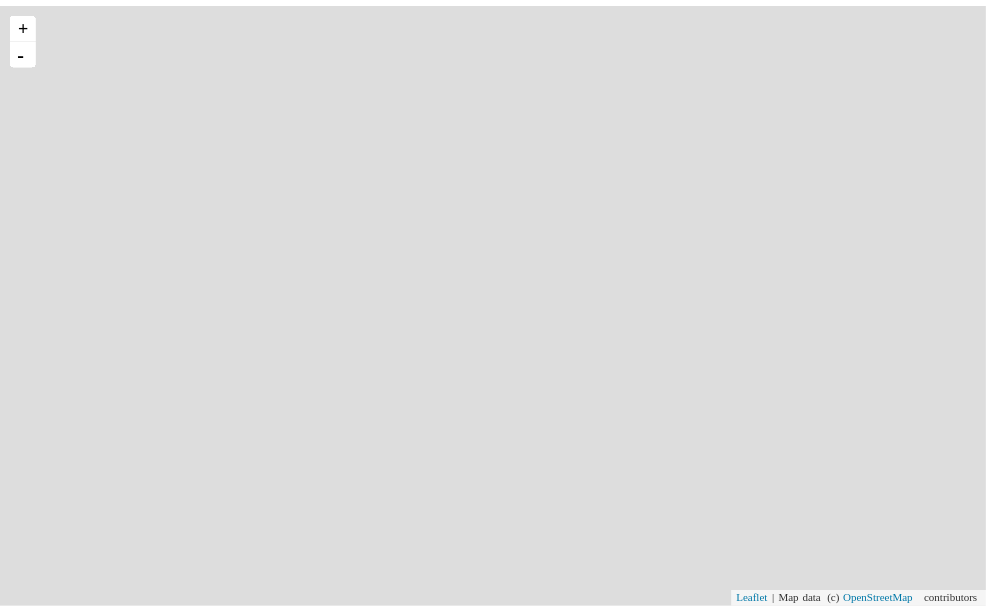

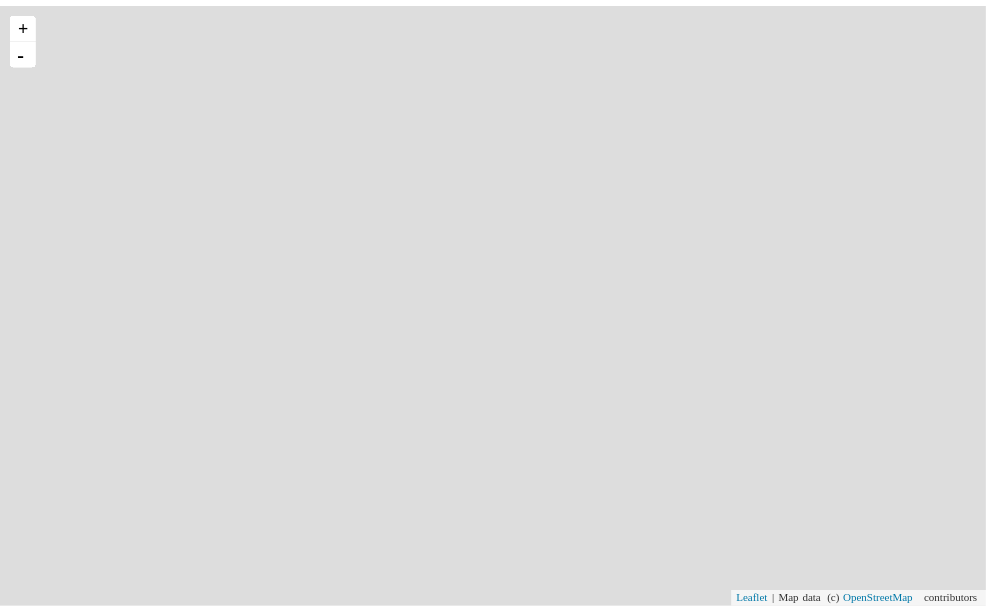

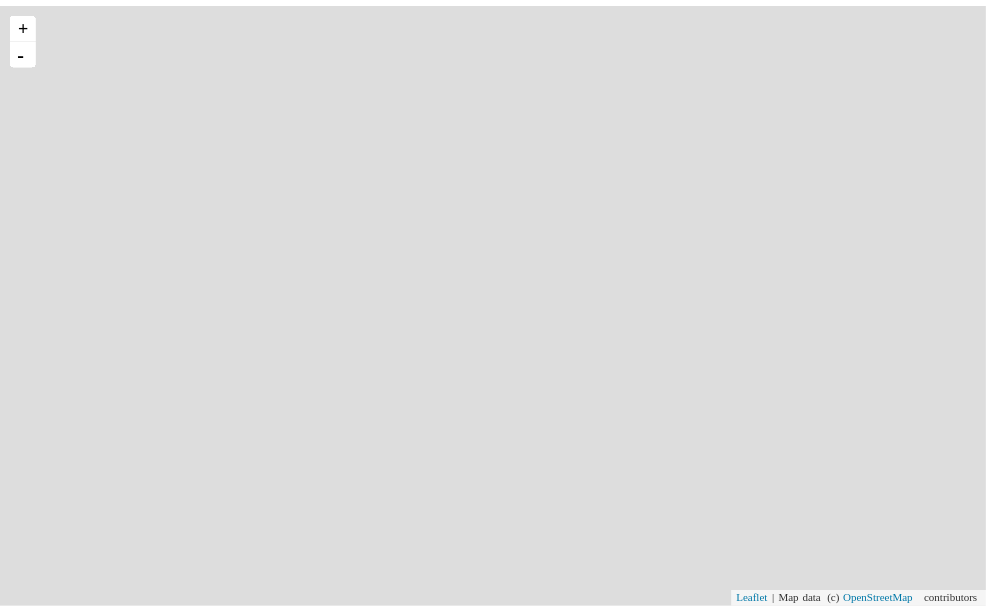

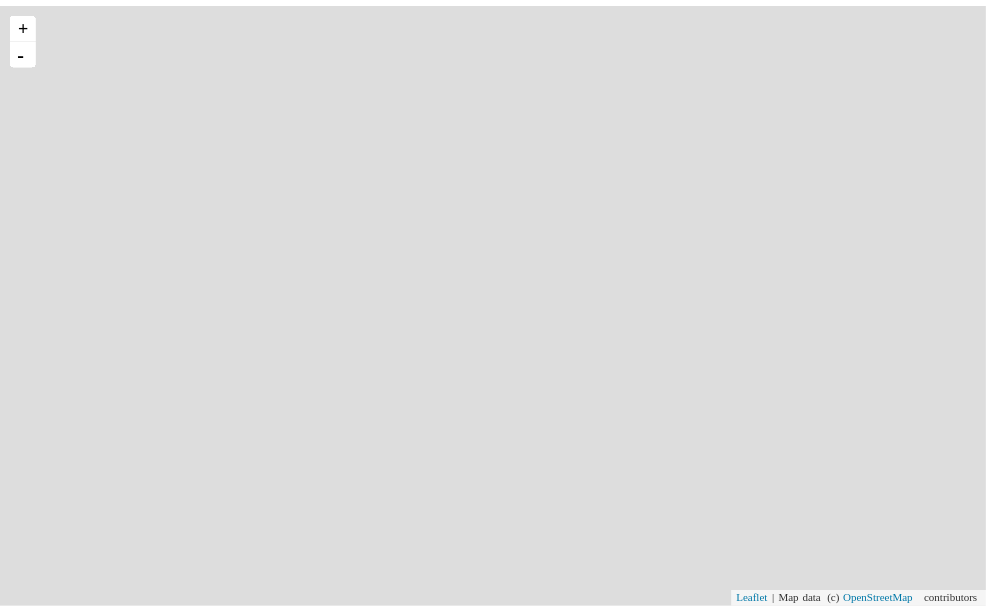

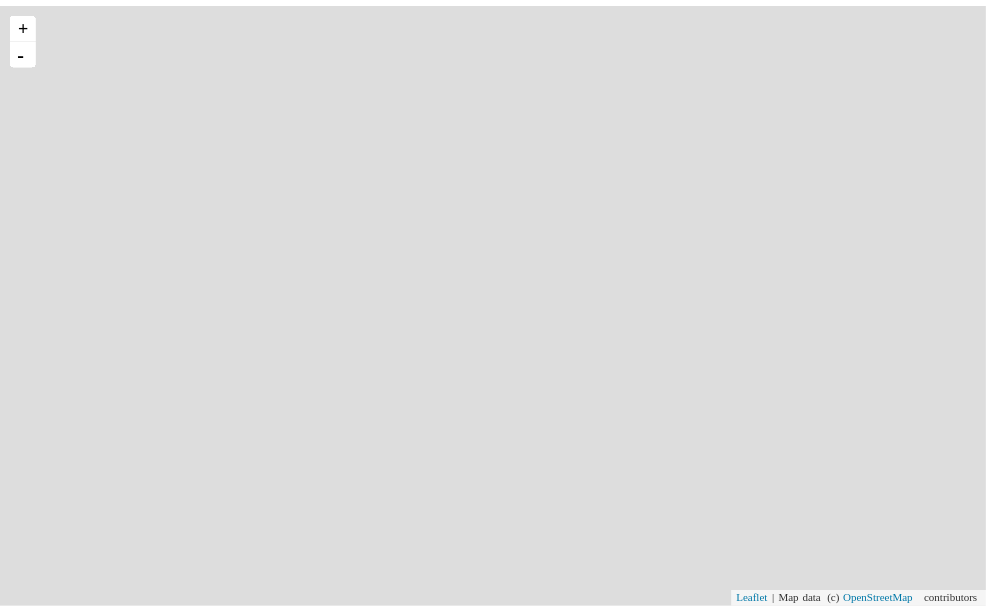

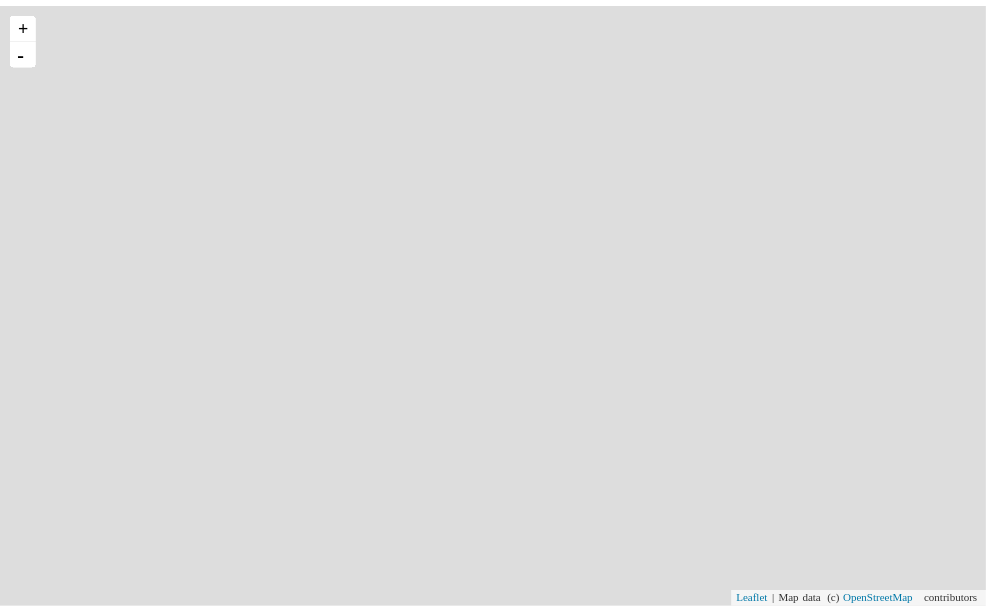

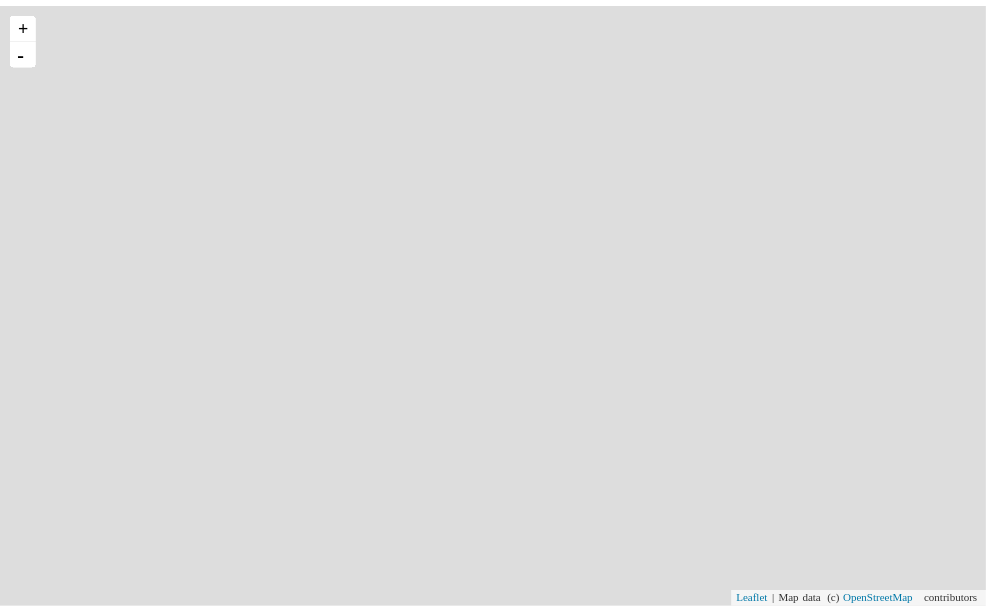

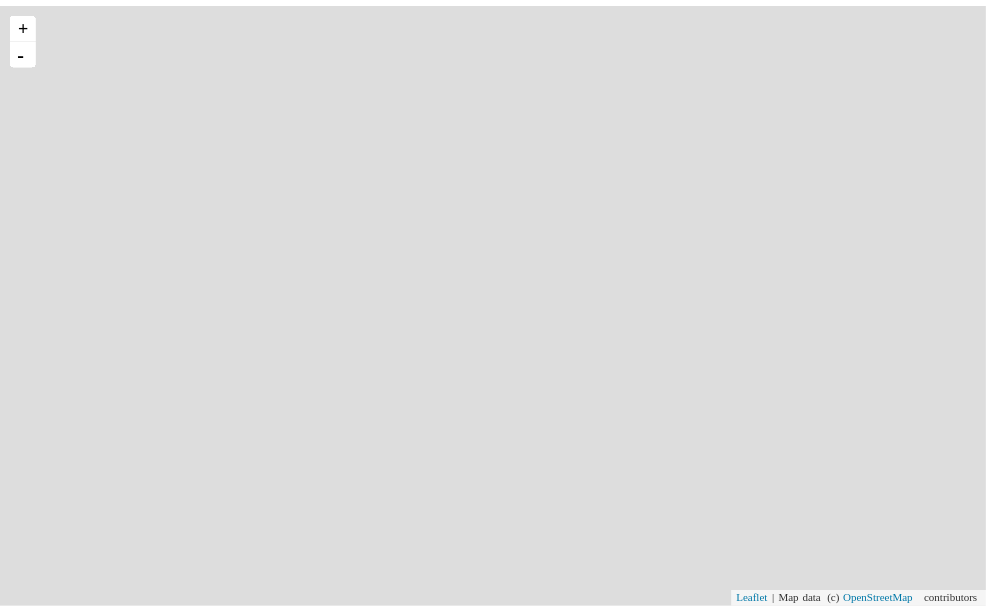

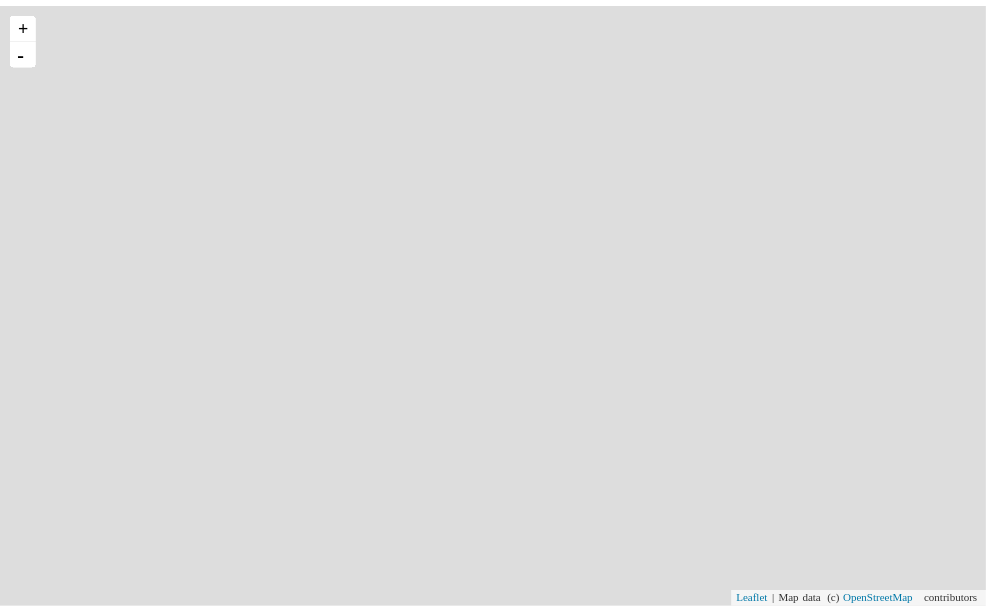

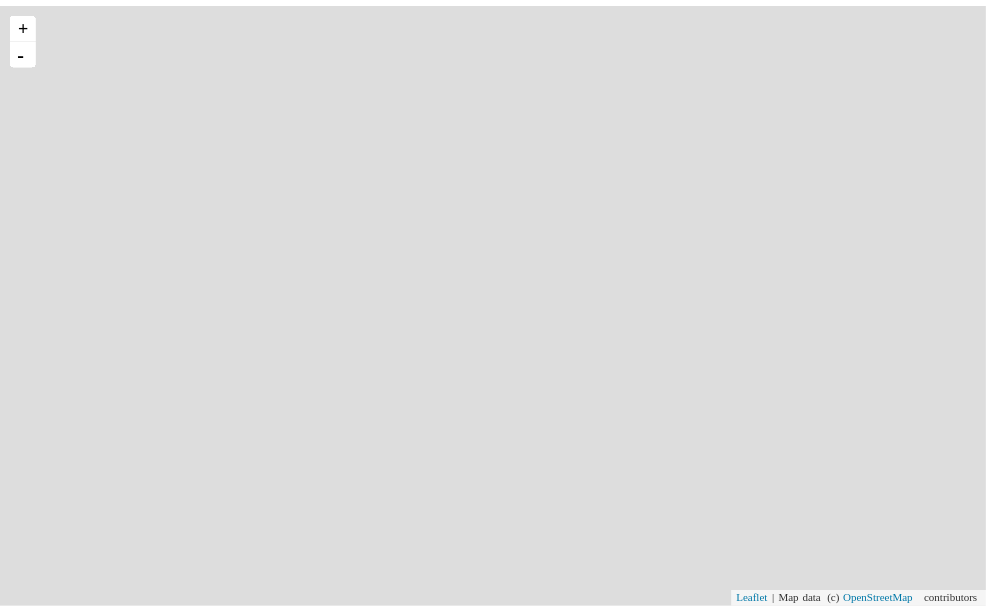

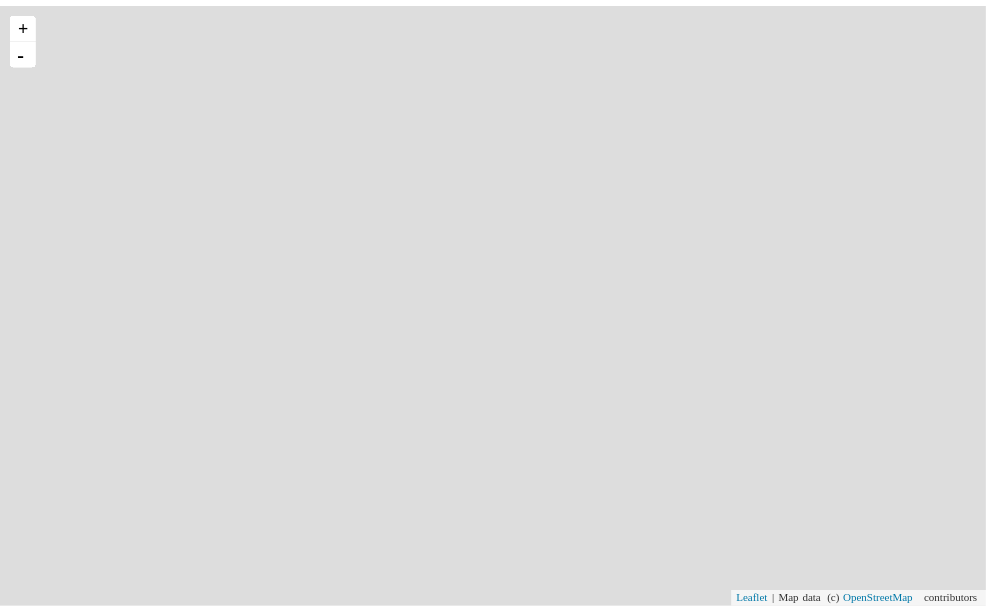

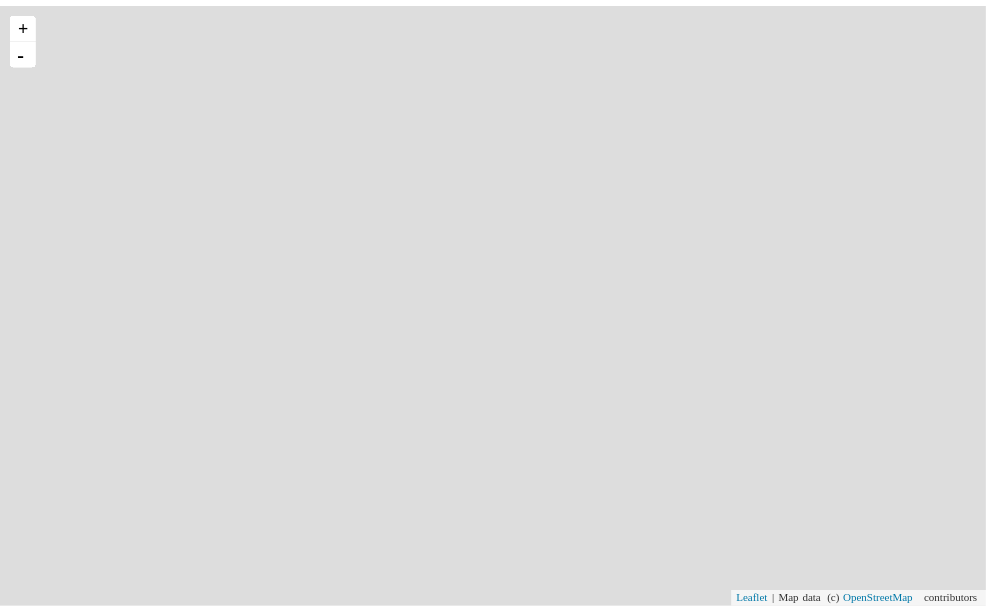

In [32]:
jupyter_orgs_maps

### Saving to file

In [33]:
def org_dict_to_csv(org_location_dict, filename, hashed_usernames = True):
    """
    Outputs a dict of users : locations to a CSV file. 
    
    Requires org_location_dict and filename, optional hashed_usernames parameter.
    
    Uses hashes of usernames by default for privacy reasons. Think carefully 
    about publishing location data about uniquely identifiable users. Hashing
    allows you to check unique users without revealing personal information.
    """
    try:
        import hashlib
        with open(filename, 'w') as f:
            f.write("user, longitude, latitude\n")
            for user, location in org_location_dict.items():
                if location is not None:
                    if hashed_usernames:
                        user_output = hashlib.sha1(user.encode('utf-8')).hexdigest()
                    else:
                        user_output = user
                    line = user_output + ", " + str(location.longitude) + ", " \
                           + str(location.latitude) + "\n"
                    f.write(line)
        f.close()
    except Exception as e:
        return e

In [126]:
def org_dict_to_geojson(org_location_dict, filename, hashed_usernames = True):
    """
    Outputs a dict of users : locations to a CSV file. 
    
    Requires org_location_dict and filename, optional hashed_usernames parameter.
    
    Uses hashes of usernames by default for privacy reasons. Think carefully 
    about publishing location data about uniquely identifiable users. Hashing
    allows you to check unique users without revealing personal information.
    """

    import hashlib
    with open(filename, 'w') as f:
        for user, location in org_location_dict.items():
            header = """
{ "type": "FeatureCollection",
    "features": [
"""
            f.write(header)
            if location is not None:
                if hashed_usernames:
                    user_output = hashlib.sha1(user.encode('utf-8')).hexdigest()
                else:
                    user_output = user

                line = """
    {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": [%s, %s]
        },
        "properties": {
            "name": "%s"
        }
    }
""" % (location.longitude, location.latitude, user_output)

                f.write(line)
        f.write("]}")
    f.close()

In [127]:
org_dict_to_geojson(orgs_location_dict['jupyter'], "org_data/jupyter.json")

In [34]:
org_dict_to_csv(orgs_location_dict['ipython'], "org_data/ipython.csv")

In [35]:
for org_name, org_location_dict in orgs_location_dict.items():
    org_dict_to_csv(org_location_dict, "org_data/" + org_name + ".csv")

In [36]:
def csv_to_org_dict(filename):
    
    
    """
    TODO: Write function to read an outputted CSV file back to an org_dict.
    Should convert lon/lat pairs to geopy Location objects for full compatibility.
    
    Also, think about a general class object for org_dicts. 
    """
    

            

Note that this will have duplicates across the organizations, as it is just getting the location data from each of the organizations and putting it into a different dictionary.